In [51]:
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from kneed import KneeLocator, DataGenerator
from itertools import permutations 
from math import sqrt
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances
from sklearn import metrics, preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.metrics import  accuracy_score, silhouette_score, pairwise
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.datasets import make_blobs
from sklearn.feature_extraction import DictVectorizer

import plotly.graph_objects as go
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from pandas.plotting import parallel_coordinates

In [3]:
# convert columns to float, set College Name to be the main value, drop State
#to account for float convert error(not necesscary column)
uni = pd.read_csv('Universities.csv') 
uni.set_index('College Name', inplace=True)
uni = uni.drop(columns=['State'])
uni = uni.astype(np.float64)
uni.head()

,Public (1)/ Private (2),# appli. rec'd,# appl. accepted,# new stud. enrolled,% new stud. from top 10%,% new stud. from top 25%,# FT undergrad,# PT undergrad,in-state tuition,out-of-state tuition,room,board,add. fees,estim. book costs,estim. personal $,% fac. w/PHD,stud./fac. ratio,Graduation rate
College Name,,,,,,,,,,,,,,,,,,
Alaska Pacific University,2.0,193.0,146.0,55.0,16.0,44.0,249.0,869.0,7560.0,7560.0,1620.0,2500.0,130.0,800.0,1500.0,76.0,11.9,15.0
University of Alaska at Fairbanks,1.0,1852.0,1427.0,928.0,NaN,NaN,3885.0,4519.0,1742.0,5226.0,1800.0,1790.0,155.0,650.0,2304.0,67.0,10.0,NaN
University of Alaska Southeast,1.0,146.0,117.0,89.0,4.0,24.0,492.0,1849.0,1742.0,5226.0,2514.0,2250.0,34.0,500.0,1162.0,39.0,9.5,39.0
University of Alaska at Anchorage,1.0,2065.0,1598.0,1162.0,NaN,NaN,6209.0,10537.0,1742.0,5226.0,2600.0,2520.0,114.0,580.0,1260.0,48.0,13.7,NaN
Alabama Agri. & Mech. Univ.,1.0,2817.0,1920.0,984.0,NaN,NaN,3958.0,305.0,1700.0,3400.0,1108.0,1442.0,155.0,500.0,850.0,53.0,14.3,40.0


In [52]:
uni.shape #check dimentions of data

(471, 18)

In [53]:
uni.columns #show column names

Index(['Public (1)/ Private (2)', '# appli. rec'd', '# appl. accepted',
       '# new stud. enrolled', '% new stud. from top 10%',
       '% new stud. from top 25%', '# FT undergrad', '# PT undergrad',
       'in-state tuition', 'out-of-state tuition', 'room', 'board',
       'add. fees', 'estim. book costs', 'estim. personal $', '% fac. w/PHD',
       'stud./fac. ratio', 'Graduation rate'],
      dtype='object')

In [5]:
# show impact of null data
find = pd.read_csv('Universities.csv') 
null_columns=uni.columns[uni.isnull().any()]
find[null_columns].isnull().sum()

# appli. rec'd               10
# appl. accepted             11
# new stud. enrolled          5
% new stud. from top 10%    235
% new stud. from top 25%    202
# FT undergrad                3
# PT undergrad               32
in-state tuition             30
out-of-state tuition         20
room                        321
board                       498
add. fees                   274
estim. book costs            48
estim. personal $           181
% fac. w/PHD                 32
stud./fac. ratio              2
Graduation rate              98
dtype: int64

In [6]:
#drop any N/As from the dataset
uni = uni.dropna(how='any',axis=0)

In [7]:
 # show N/A gone
null_columns=uni.columns[uni.isnull().any()]
find[null_columns].isnull().sum()

Series([], dtype: float64)

In [9]:
# Euclidean distance matrix
NormU = (uni - uni.mean())/uni.std()
u_norm = pairwise.pairwise_distances(NormU[['# appl. accepted', 'estim. personal $']], 
                                     metric='euclidean')
pd.DataFrame(u_norm, columns=uni.index, index=uni.index).head(5)

College Name,Alaska Pacific University,University of Alaska Southeast,Birmingham-Southern College,Huntingdon College,Talladega College,University of Alabama at Birmingham,Arkansas College (Lyon College),Hendrix College,John Brown University,Harding University,...,Lawrence University,Ripon College,St. Norbert College,Viterbo College,University of Wisconsin-Stout,Univ. of Wisconsin at Eau Claire,Wisconsin Lutheran College,Alderson-Broaddus College,Marshall University,University of Wyoming
College Name,,,,,,,,,,,,,,,,,,,,,
Alaska Pacific University,0.000000,0.495848,0.897496,0.605361,0.560322,1.118892,1.029365,0.496311,0.243098,0.940396,...,0.833785,1.254651,0.732200,1.102676,0.814143,1.782084,0.146837,0.461897,1.408641,0.547179
University of Alaska Southeast,0.495848,0.000000,0.427828,0.184867,0.653415,1.589311,0.537939,0.247592,0.298754,0.529965,...,0.430244,0.766404,0.458825,1.596387,1.135359,1.764424,0.349079,0.947987,1.532952,0.746957
Birmingham-Southern College,0.897496,0.427828,0.000000,0.294576,0.818787,1.925384,0.178328,0.443176,0.664007,0.192272,...,0.180716,0.368294,0.393034,1.972781,1.362702,1.656819,0.755967,1.320433,1.564691,0.954835
Huntingdon College,0.605361,0.184867,0.294576,0.000000,0.588886,1.640115,0.446209,0.167195,0.369517,0.354335,...,0.250387,0.660016,0.288767,1.679262,1.114590,1.614743,0.467008,1.026661,1.426171,0.708799
Talladega College,0.560322,0.653415,0.818787,0.588886,0.000000,1.177192,0.995596,0.427599,0.443449,0.739059,...,0.661282,1.170085,0.451796,1.299864,0.546012,1.223540,0.547977,0.710146,0.896362,0.146800


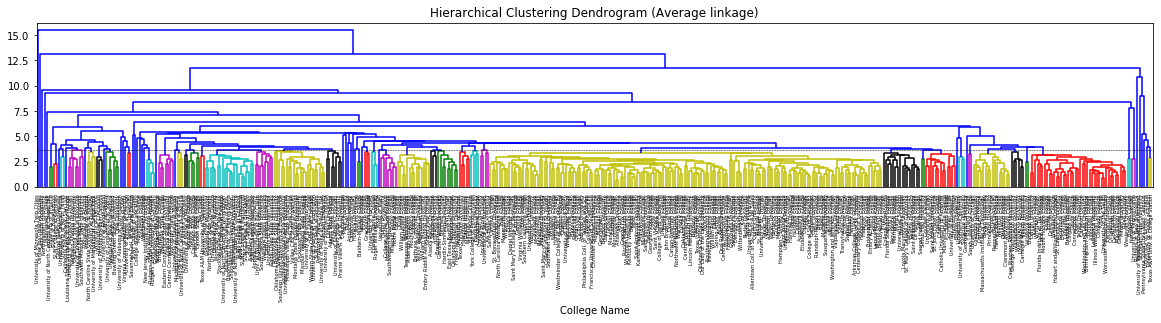

In [10]:
#Hierarchial breakdown of data
Z = linkage(NormU, method='average')

fig = plt.figure(figsize=(20, 6))
fig.subplots_adjust(bottom=0.5)
plt.title('Hierarchical Clustering Dendrogram (Average linkage)')
plt.xlabel('College Name')
dendrogram(Z, labels=NormU.index, color_threshold=3.6)
plt.axhline(y=3.6, color='black', linewidth=0.5, linestyle='dashed')
plt.show()

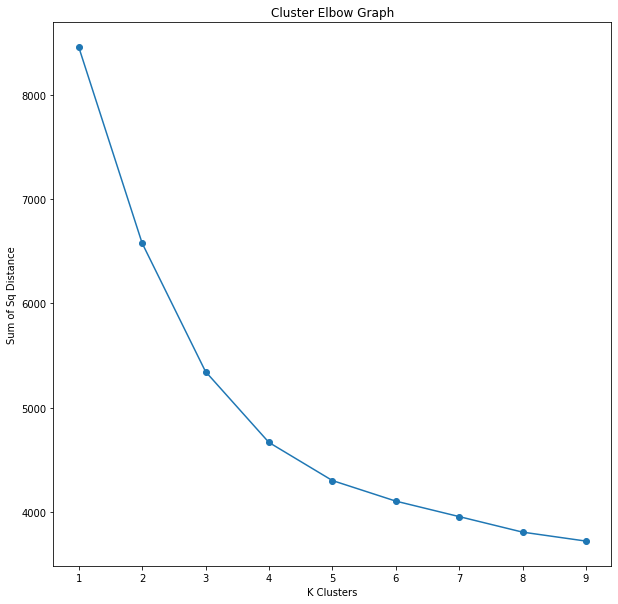

In [11]:
# This graph will show the optimal number of clusters. 4 seems to be the best, paired with the silhouette score 
#above for confirmation.
ceg= [] 
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(NormU)
    ceg.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(10, 10))
plt.plot(list_k, ceg, '-o')
plt.xlabel('K Clusters')
plt.ylabel('Sum of Sq Distance')
plt.title("Cluster Elbow Graph");

In [54]:
#Checking the k cluster accuracy with a silhouette score
labels = km.labels_
metrics.silhouette_score(NormU, labels, metric='euclidean')

0.5519740585150167

In [13]:
#Setting up variables for Kmeans clustering
NormU,y = make_blobs(centers=5, n_samples=471, random_state=0)


In [28]:
#Fitting model and showing the cluster centers
km = KMeans(n_clusters=5, init='k-means++')
km.fit(NormU)
print(km.cluster_centers_)

[[ 1.85069646  0.75038291]
 [ 9.23235538 -2.3279484 ]
 [ 0.81499069  4.45415569]
 [-1.45044708  7.7672503 ]
 [-1.71063514  2.79708969]]


In [30]:
#Check array produced by kmeans clustering
km.labels_

array([0, 0, 2, 2, 2, 0, 1, 3, 1, 1, 1, 0, 4, 1, 1, 1, 4, 2, 1, 0, 1, 1,
       1, 0, 2, 0, 0, 3, 3, 2, 2, 1, 4, 0, 0, 2, 3, 1, 0, 2, 1, 4, 0, 4,
       0, 0, 3, 0, 0, 1, 3, 1, 0, 1, 0, 4, 4, 3, 0, 1, 1, 4, 2, 2, 1, 4,
       1, 0, 3, 1, 2, 4, 1, 4, 1, 4, 2, 4, 1, 1, 4, 4, 2, 1, 0, 2, 0, 4,
       1, 3, 3, 3, 2, 3, 1, 0, 0, 4, 4, 3, 0, 2, 2, 4, 3, 1, 2, 2, 2, 4,
       1, 2, 3, 4, 4, 0, 2, 1, 2, 2, 2, 4, 0, 2, 2, 2, 0, 4, 1, 1, 3, 1,
       1, 3, 2, 3, 3, 0, 4, 3, 2, 4, 4, 0, 1, 4, 3, 0, 4, 2, 2, 3, 0, 4,
       2, 1, 3, 2, 0, 3, 0, 2, 4, 0, 4, 2, 2, 3, 0, 2, 0, 3, 2, 2, 3, 3,
       0, 4, 4, 2, 0, 2, 0, 2, 3, 3, 4, 1, 0, 1, 3, 0, 4, 0, 2, 4, 0, 1,
       1, 4, 2, 3, 1, 2, 3, 3, 1, 0, 1, 1, 2, 4, 3, 2, 1, 3, 2, 0, 2, 3,
       0, 0, 2, 3, 4, 2, 0, 0, 4, 0, 0, 4, 4, 3, 3, 0, 4, 2, 2, 0, 1, 2,
       3, 4, 4, 1, 2, 4, 2, 0, 2, 3, 1, 0, 1, 4, 1, 0, 2, 0, 1, 3, 1, 4,
       1, 4, 2, 1, 3, 4, 1, 0, 0, 1, 4, 1, 0, 2, 4, 2, 4, 2, 3, 1, 4, 2,
       1, 3, 4, 2, 0, 0, 4, 0, 2, 4, 0, 0, 2, 1, 0,

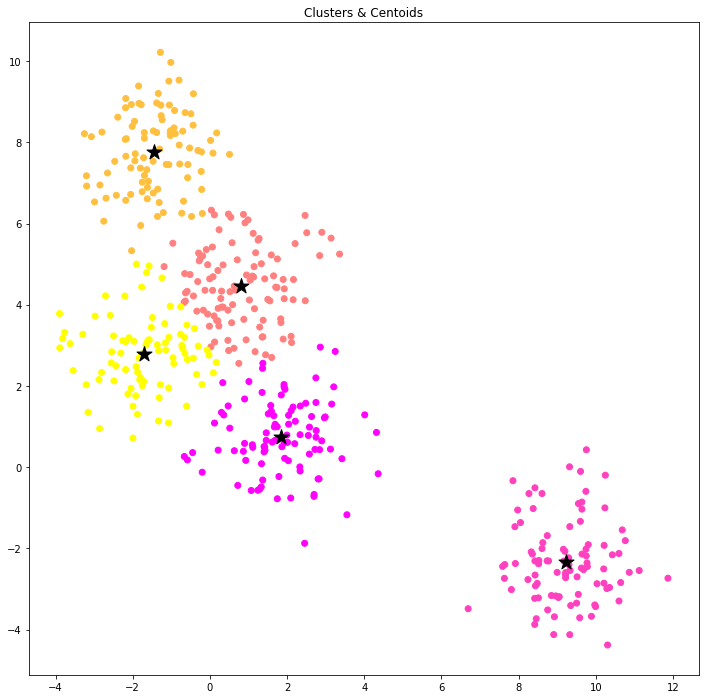

In [49]:
#Figure shows the five clusters that were created and the centoids(marked by stars)
plt.figure(figsize=(12, 12))
plt.scatter(NormU[:,0],NormU[:,1], c=km.labels_, cmap='spring');
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], s=250, marker='*', color='black')
plt.title("Clusters & Centoids");


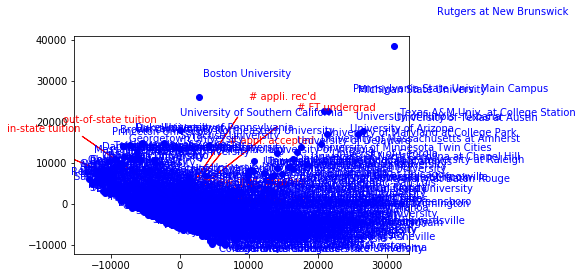

In [50]:
## This was a cool little bit of code from https://github.com/teddyroland/python-biplot/blob/master/biplot.py 
## that lables the datapoints. Going further with this code would allow you to describe
## data in the terms of distance from centoids

my_csv =  'Universities.csv' 

dat = pd.read_csv(my_csv, index_col=0)
dat = dat.drop(columns=['State','Public (1)/ Private (2)'])
dat = dat.dropna(how='any',axis=0)
n = len(dat.columns)

pca = PCA(n_components = n)

pca.fit(dat)

xvector = pca.components_[0] 
yvector = pca.components_[1]

xs = pca.transform(dat)[:,0] 
ys = pca.transform(dat)[:,1]


for i in range(len(xvector)):
    plt.arrow(0, 0, xvector[i]*max(xs), yvector[i]*max(ys),
              color='r', width=0.0005, head_width=0.0025)
    plt.text(xvector[i]*max(xs)*1.2, yvector[i]*max(ys)*1.2,
             list(dat.columns.values)[i], color='r')

for i in range(len(xs)):
    plt.plot(xs[i], ys[i], 'bo')
    plt.text(xs[i]*1.2, ys[i]*1.2, list(dat.index)[i], color='b')

plt.show()

In [16]:
#This breakdown shows which schools were clustered into which group
memb = fcluster(linkage(NormU, 'average'), 4, criterion='maxclust')
memb = pd.Series(memb, index=uni.index)
for key, item in memb.groupby(memb):
    print(key, ': ', ', '.join(item.index))

1 :  Arkansas College (Lyon College), John Brown University, Harding University, Northern Arizona University, Claremont McKenna College, Harvey Mudd College, Pitzer College, Fresno Pacific College, Southern California College, St. Mary's College of California, University of San Francisco, University of Southern Colorado, Trinity College, Wesleyan University, Bethune Cookman College, Embry Riddle Aeronautical University, Rollins College, Morehouse College, Spelman College, University of Hawaii at Manoa, Clarke College, Dordt College, Grinnell College, Mount Mercy College, University of Northern Iowa, University of Dubuque, Albertson College, Knox College, Saint Xavier University, Franklin College, Saint Mary-of-the-Woods College, Bethel College, Centenary College of Louisiana, Grambling State University, Loyola University, Tulane University, Bridgewater State College, Goucher College, University of Minnesota Twin Cities, Columbia College, Saint Louis University, Washington University, W

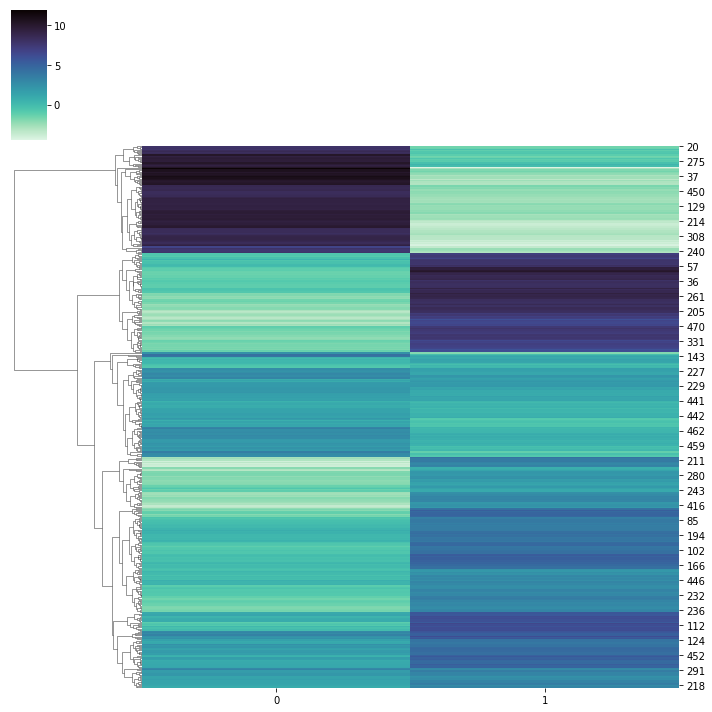

In [32]:
#This is another view of hierarchial clustering from class demonstration
uni.index = ['{}: {}'.format(cluster, state) for cluster, state in zip(memb, uni.index)]
sns.clustermap(NormU, method='average', col_cluster=False,  cmap="mako_r")
plt.show()

In [55]:
#create variable to insert into code for showing clusters and distance
row_clusters = linkage(km.cluster_centers_,
                      method='complete',
                      metric='euclidean')

In [56]:
#Measure of clusters and distance
pd.DataFrame(row_clusters,
            columns=['row 1', 'row 2',
                     'distance', 'Item Count'],
             index=['Cluster %d' % (i +1) for i in range(row_clusters.shape[0])])

,row 1,row 2,distance,Item Count
Cluster 1,2.0,4.0,3.020704,2.0
Cluster 2,0.0,5.0,4.107565,3.0
Cluster 3,3.0,6.0,7.754610,4.0
Cluster 4,1.0,7.0,14.698140,5.0


In [57]:
#setup for further distance calculations
km = KMeans(n_clusters=5)
alldistances = km.fit_transform(NormU)
totalDistance = np.min(NormU, axis=1).sum()

In [58]:
print(totalDistance)

-352.45577779379664


In [59]:
print(alldistances)

[[ 3.97755816  8.59573777  3.64613416  7.71707203  0.78515146]
 [ 4.46334665  7.61895159  4.57772586  8.36635587  0.61763581]
 [ 1.15053523 10.56386623  4.17042166  4.14726828  4.37811178]
 ...
 [ 4.84805511 15.53643182  5.60237454  0.84078319  8.56261394]
 [ 4.51859123 14.82653087  6.02918208  1.25721757  8.36120226]
 [ 4.12547918 14.91216196  3.95192205  1.68800181  7.42678325]]
